In [ ]:
import numpy as np
import pandas as pd

### Monte Carlo

In [ ]:
def Monte_Carlo():
    mean_arr = -np.ones(d['rep_num'])
    max_list = []

    for i in range(d['rep_num']):
        chosen_matrix = np.zeros((d['sim_num'], d['n']+1))
        chosen_matrix[:,0] = np.log(d['St'])

        S_change_mean = (d['r']-d['q']-(d['sigma']**2)/2)*d['delta_t']
        S_std = d['sigma'] * np.sqrt(d['delta_t'])

        for t in range(1, d['n']+1):
          change_arr = np.random.normal(S_change_mean, S_std, d['sim_num'])
          chosen_matrix[:, t] = chosen_matrix[:, t-1] + change_arr
        chosen_matrix = np.exp(chosen_matrix)

        if d['n_before_t'] != 0:
          before_matrix = np.full((d['sim_num'], d['n_before_t']), d['Save_t'])
          all_matrix = np.concatenate((before_matrix,chosen_matrix), axis=1)
          #print(all_matrix)
          #print(all_matrix.shape)
        else:
          all_matrix = chosen_matrix

        ave_arr = np.average(all_matrix, axis=1)
        #print("ave_arr\n", ave_arr)
        #print("ave_arr shape ", ave_arr.shape)
        payoff = np.max((np.zeros(d['sim_num']), ave_arr - d['K']), axis=0)
        #print("payoff array:\n", payoff)
        #print("payoff shape", payoff.shape)
        mean_arr[i] = payoff.mean() *np.exp(-d['r'] * (d['T'] - d['t']))
    if any(m < 0 for m in mean_arr):
        print("There is negative element in mean_arr.")
    return mean_arr.mean(), mean_arr.std()

### Tree

In [ ]:
def find_call(target_A, A1, A2, c1, c2):
  #print("Find call------------------")
  #print(target_A, A1, A2, c1, c2)
  w1 = (A1 - target_A)/(A1 - A2)
  w2 = (target_A - A2)/(A1 - A2)
  return w1 * c2 + w2 * c1

In [ ]:
class S_node():
    def __init__(self, S):
      self.S = S
      self.K = d['K']
      self.ave_list = np.array([0])
      self.value_EC = []
      self.value_AC = []
      self.Au_list = []
      self.Ad_list = []
    def set_ave_list(self, A_list):
      self.ave_list = A_list

    def add_call_price(self, Au, Ad, p, u_node, d_node, k_pos):
      self.Au_list.append(Au)
      self.Ad_list.append(Ad)
      # Au
      found = False
      if len(u_node.ave_list) == 1:
        EC_u = u_node.value_EC[0]
        AC_u = u_node.value_AC[0]
        found = True
      else:
        for k in range(d['M']+1):
          #print("Au, compare_A = ", Au, u_node.ave_list[k])
          if Au == u_node.ave_list[k]:
            EC_u = u_node.value_EC[k]
            AC_u = u_node.value_AC[k]
            found = True
            #print("Find the same item at k = ", k)
            #print("EC_u = %f, AC_u = %f" % (EC_u, AC_u))
            break
          elif Au > u_node.ave_list[k]:
            # print("k = ", k)
            found = True
            EC_u = find_call(Au, A1=u_node.ave_list[k-1], A2=u_node.ave_list[k], c1=u_node.value_EC[k-1], c2=u_node.value_EC[k])
            AC_u = find_call(Au, A1=u_node.ave_list[k-1], A2=u_node.ave_list[k], c1=u_node.value_AC[k-1], c2=u_node.value_AC[k])
            #print("Find the smaller item at k = ", k)
            #print("EC_u = %f, AC_u = %f" % (EC_u, AC_u))
            break
      if not found:
        EC_u =  u_node.value_EC[d['M']]
        AC_u =  u_node.value_AC[d['M']]
        #print("not found C_u")
        #print("Au = ", Au, "min u_node = ", u_node.ave_list[d['M']])
      #Av
      found = False
      if len(d_node.ave_list) == 1:
        EC_d = d_node.value_EC[0]
        AC_d = d_node.value_AC[0]
        found = True
      else:
        for k in range(d['M']+1):
          #print("Ad, compare_A = ", Ad, d_node.ave_list[k])
          if Ad == d_node.ave_list[k]:
            #print("Find the same item at k = ", k)
            EC_d = d_node.value_EC[k]
            AC_d = d_node.value_AC[k]
            found = True
            #print("EC_d = %f, AC_d = %f" % (EC_d, AC_d))
            break
          elif Ad > d_node.ave_list[k]:
            #print("Find smaller item at k = ", k)
            EC_d = find_call(Ad, A1=d_node.ave_list[k-1], A2=d_node.ave_list[k], c1=d_node.value_EC[k-1], c2=d_node.value_EC[k])
            AC_d = find_call(Ad, A1=d_node.ave_list[k-1], A2=d_node.ave_list[k], c1=d_node.value_AC[k-1], c2=d_node.value_AC[k])
            found = True
            #print("EC_d = %f, AC_d = %f" % (EC_d, AC_d))
            break
      if not found:
        EC_d =  u_node.value_EC[d['M']]
        AC_d =  u_node.value_AC[d['M']]
      #print("found = ", found)
      #print("EC_u = %f, EC_d = %f, AC_u = %f, AC_d = %f" % (EC_u, EC_d, AC_u, AC_d))
      exercise_value = np.max((self.ave_list[k_pos] - d['K'], 0))
      holding_value = (p * AC_u + (1-p) * AC_d) * np.exp(-d['r'] * d['delta_t'])
      AC_value = np.max((exercise_value, holding_value))
      #print("exercise and holding value", exercise_value, holding_value)
      self.value_EC.append((p * EC_u + (1-p) * EC_d) * np.exp(-d['r'] * d['delta_t']))
      self.value_AC.append(AC_value)
      del EC_u, EC_d, AC_u, AC_d
    def print(self):
      print("S = %4f" % self.S)
      print("S_ave list = ", end = '')
      print(self.ave_list)
      print("value_EC = ", end = '')
      print(self.value_EC)
      print("value_AC = ", end = '')
      print(self.value_AC)
      print("Au_list = ", end = '')
      print(self.Au_list)
      print("Ad_list = ", end = '')
      print(self.Ad_list)

In [ ]:
class Binomial_tree():
    def __init__(self):
        self.u = np.exp(d['sigma'] * np.sqrt(d['delta_t']))
        self.d = np.exp(-d['sigma'] * np.sqrt(d['delta_t']))
        self.p = (np.exp((d['r'] -d['q'])*d['delta_t']) - self.d)/(self.u - self.d)
        self.K = d['K']
        self.St = d['St']

    def build_tree(self, spaced = "linear"):
        self.nodes = []
        start_node = S_node(d['St'])
        start_node.set_ave_list(np.array([d['St']]))
        self.nodes.append([start_node])

        u_list = []
        d_list = []
        for i in range(d['n']):
            u_list.append(self.u ** (i+1))
            d_list.append(self.d ** (i+1))

        for i in range(1, d['n']+1):
            self.nodes.append([])
            for j in range(i+1):
                a = i-j # new_S = St * u**(i-j) * d**(j)}
                b = j
                if a > b:
                    new_S = u_list[a-b-1] * d['St']
                elif a < b:
                    new_S = d_list[b-a-1] * d['St']
                else: # a==b
                    new_S = d['St']
                print("i = %d, j = %d" % (i,j))
                new_node = S_node(new_S)
                A_max = ((d['n_before_t']+1) * d['Save_t'] + self.St * self.u * (1 - self.u**a)/(1 - self.u) + \
                         self.St * (self.u**a) * self.d * (1 - self.d**j)/(1 - self.d))/(i+d['n_before_t']+1)
                A_min = ((d['n_before_t']+1) * d['Save_t'] + self.St * self.d * (1 - self.d**j)/(1 - self.d) + \
                         self.St * (self.d**j) * self.u * (1 - self.u**a)/(1 - self.u))/(i+d['n_before_t']+1)
                print("A_max = %f, A_min = %f" % (A_max, A_min))
                if A_max == A_min:
                  A_list = np.array([A_max])
                else:
                  if spaced == "linear":
                    A_list = np.concatenate((np.arange(A_max,A_min,(A_min - A_max)/d['M']), np.array([A_min])))
                  else:
                    log_max = np.log(A_max)
                    log_min = np.log(A_min)
                    temp = np.exp(np.arange(log_max, log_min, (log_min - log_max)/d['M']))
                    #print(temp)
                    A_list = np.concatenate([temp, np.array([A_min])])
                #print("A_list : ", A_list)
                new_node.set_ave_list(A_list)
                self.nodes[i].append(new_node)
                # (self.nodes[i][j]).print()

    def backward_induction(self):
        discnt = np.exp(- d['r'] * d['delta_t'])
        for i in range(d['n'],-1,-1):
          for j in range(len(self.nodes[i])):
            cur_node = self.nodes[i][j]
            if i == d['n']:
              zero_arr = np.zeros(len(cur_node.ave_list))
              # print("zero arr", end='')
              # print(zero_arr)
              cur_node.value_EC = np.max((cur_node.ave_list- self.K, zero_arr), axis=0).tolist()
              cur_node.value_AC = np.max((cur_node.ave_list- self.K, zero_arr), axis=0).tolist()
              # print("cur_node.value_EC = ", end = '')
              # print(cur_node.value_EC)
            else:
              #print("-------------------------------------------")
              #print("i = %d, j = %d" % (i,j))
              for k in range(len(cur_node.ave_list)):
                Au = ((i+d['n_before_t']+1) * cur_node.ave_list[k] + self.St * self.u**(i+1-j) * self.d**j)/(i+d['n_before_t']+2)
                Ad = ((i+d['n_before_t']+1) * cur_node.ave_list[k] + self.St * self.u**(i+1-j-1) * self.d**(j+1))/(i+d['n_before_t']+2)
                #print("i, j, k = ", i, j, k)
                #print("Au = ", Au, ", Ad = ", Ad)
                cur_node.add_call_price(Au = Au, Ad = Ad, p = self.p, u_node = self.nodes[i+1][j], d_node = self.nodes[i+1][j+1], k_pos = k)

        self.price_EC = self.nodes[0][0].value_EC[0]
        self.price_AC = self.nodes[0][0].value_AC[0]

    def print(self):
        for i in range(len(self.nodes)):
          for j in range(len(self.nodes[i])):
            print("i, j = %d, %d" % (i,j))
            self.nodes[i][j].print()

### Demo

In [ ]:
# Read files
d = {}

with open('HW5_params_2.txt','r') as file:
    line = file.readline().strip('\n')
    while line:
        key, value = line.split('=')[0], float(line.split('=')[1])
        d[key] = value
        line = file.readline().strip('\n')
d['n'] = int(d['n'])
d['M'] = int(d['M'])
d['sim_num'] = int(d['sim_num'])
d['rep_num'] = int(d['rep_num'])
d['delta_t'] = (d['T'] - d['t'])/d['n']
d['n_before_t'] = int(d['n'] * (d['t'] / (d['T'] - d['t'])))
d

{'K': 50.0,
 'M': 3,
 'Save_t': 50.0,
 'St': 50.0,
 'T': 0.5,
 'delta_t': 0.08333333333333333,
 'n': 3,
 'n_before_t': 3,
 'q': 0.05,
 'r': 0.1,
 'rep_num': 20,
 'sigma': 0.8,
 'sim_num': 10000,
 't': 0.25}

In [ ]:
%%time
sim_mean, sim_std = Monte_Carlo()
print("Monte Carlo:  EC price = %4f, and the C.I. = [%4f, %4f]"%(sim_mean, sim_mean - 2*sim_std, sim_mean + 2*sim_std))
BTree = Binomial_tree()
BTree.build_tree()
BTree.backward_induction()
print("Binomial tree model: EC price = %4f, and AC price = %4f\n" % (BTree.price_EC, BTree.price_AC))

Monte Carlo:  EC price = 2.500438, and the C.I. = [2.413165, 2.587710]
i = 1, j = 0
A_max = 52.597838, A_min = 52.597838
i = 1, j = 1
A_max = 47.937870, A_min = 47.937870
i = 2, j = 0
A_max = 57.056991, A_min = 57.056991
i = 2, j = 1
A_max = 52.164865, A_min = 48.281558
i = 2, j = 2
A_max = 45.199040, A_min = 45.199040
i = 3, j = 0
A_max = 63.187038, A_min = 63.187038
i = 3, j = 1
A_max = 57.904448, A_min = 50.382649
i = 3, j = 2
A_max = 50.382649, A_min = 44.411942
i = 3, j = 3
A_max = 42.314631, A_min = 42.314631
Binomial tree model: EC price = 2.542673, and AC price = 2.614542

CPU times: user 67.3 ms, sys: 1.01 ms, total: 68.3 ms
Wall time: 70.7 ms


### Bonus 1

In [ ]:
M_list = np.arange(50, 350, 50)
M_list

array([ 50, 100, 150, 200, 250, 300])

In [ ]:
Tree_EC_1 = []
Tree_AC_1 = []

sim_mean, sim_std = Monte_Carlo()
print("Monte Carlo:  EC price = %4f, and the C.I. = [%4f, %4f]"%(sim_mean, sim_mean - 2*sim_std, sim_mean + 2*sim_std))

for i in range(len(M_list)):
  d['M'] = M_list[i]
  print("M = %d" % d['M'])
  BTree_1 = Binomial_tree()
  BTree_1.build_tree(spaced = 'linear')
  BTree_1.backward_induction()
  Tree_EC_1.append(BTree_1.price_EC)
  Tree_AC_1.append(BTree_1.price_AC)
  print("Binomial tree model: EC price = %4f, and AC price = %4f\n" % (BTree_1.price_EC, BTree_1.price_AC))

Monte Carlo:  EC price = 2.346450, and the C.I. = [2.272349, 2.420552]
M = 50
Binomial tree model: EC price = 2.551682, and AC price = 2.662303

M = 100
Binomial tree model: EC price = 2.379472, and AC price = 2.507866

M = 150
Binomial tree model: EC price = 2.352676, and AC price = 2.489853

M = 200
Binomial tree model: EC price = 2.344208, and AC price = 2.484708

M = 250
Binomial tree model: EC price = 2.341091, and AC price = 2.482208

M = 300
Binomial tree model: EC price = 2.338750, and AC price = 2.480469



In [ ]:
Tree_EC_2 = []
Tree_AC_2 = []

sim_mean, sim_std = Monte_Carlo()
print("Monte Carlo:  EC price = %4f, and the C.I. = [%4f, %4f]"%(sim_mean, sim_mean - 2*sim_std, sim_mean + 2*sim_std))

for i in range(len(M_list)):
  d['M'] = M_list[i]
  print("M = %d" % d['M'])
  BTree_2 = Binomial_tree()
  BTree_2.build_tree(spaced = 'log')
  BTree_2.backward_induction()
  Tree_EC_2.append(BTree_2.price_EC)
  Tree_AC_2.append(BTree_2.price_AC)
  print("Binomial tree model: EC price = %4f, and AC price = %4f\n" % (BTree_2.price_EC, BTree_2.price_AC))

Monte Carlo:  EC price = 2.323843, and the C.I. = [2.258934, 2.388753]
M = 50
Binomial tree model: EC price = 2.496210, and AC price = 2.610177

M = 100
Binomial tree model: EC price = 2.360456, and AC price = 2.494568

M = 150
Binomial tree model: EC price = 2.347864, and AC price = 2.487504

M = 200
Binomial tree model: EC price = 2.341609, and AC price = 2.482405

M = 250
Binomial tree model: EC price = 2.338758, and AC price = 2.480581

M = 300
Binomial tree model: EC price = 2.337101, and AC price = 2.479631



In [ ]:
import matplotlib.pyplot as plt

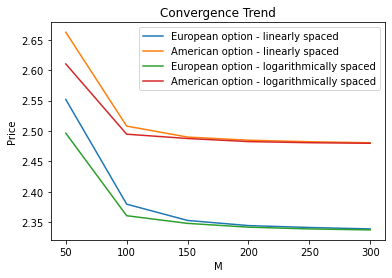

In [ ]:
x = M_list
y1, y2, y3, y4 = Tree_EC_1, Tree_AC_1, Tree_EC_2, Tree_AC_2
plt.plot(x, y1, label = "European option - linearly spaced")
plt.plot(x, y2, label = "American option - linearly spaced")
plt.plot(x, y3, label = "European option - logarithmically spaced")
plt.plot(x, y4, label = "American option - logarithmically spaced")
plt.xlabel("M")
plt.ylabel("Price")
plt.title("Convergence Trend")
plt.legend()
plt.show()
plt.close()

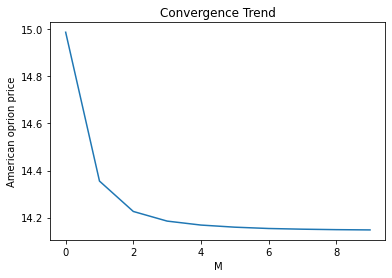

In [ ]:
plt.plot(Tree_AC)
plt.xlabel("M")
plt.ylabel("American oprion price")
plt.title("Convergence Trend")
plt.show()
plt.close()

In [ ]:
BTree.print()